<ipython-input-1-02b9ef3e438f>:200: RuntimeWarning: invalid value encountered in sqrt
  iac_3= Idc/np.sqrt(1+0.02*(25.62-133.9*Ik_2+288.8* Ik_2**2- 334.5* Ik_2**3 +226.5* Ik_2**4-89.73* Ik_2**5+ 19.31* Ik_2**6-1.744*Ik_2**7))


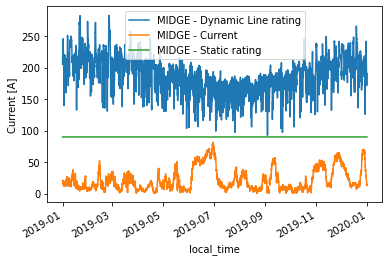

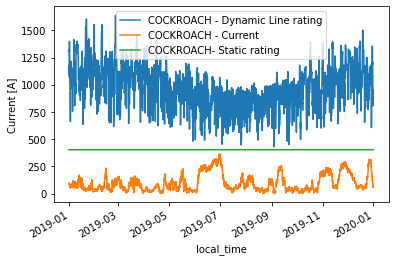

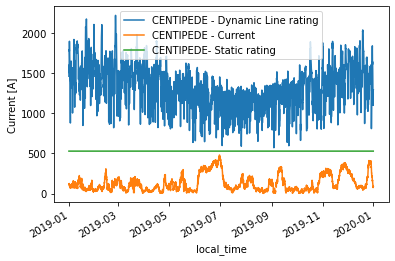

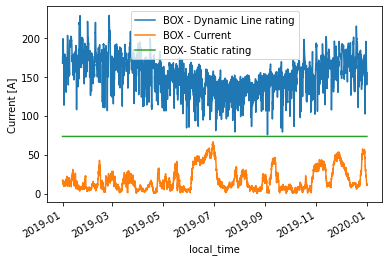

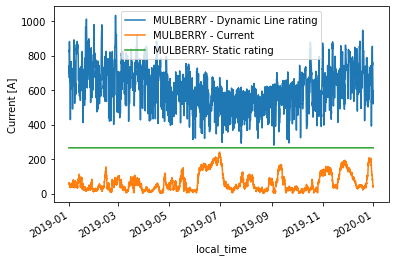

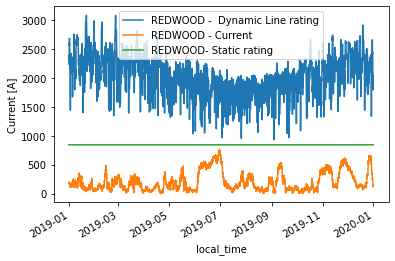

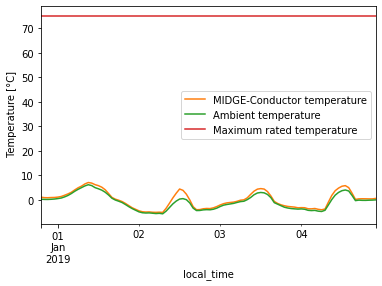

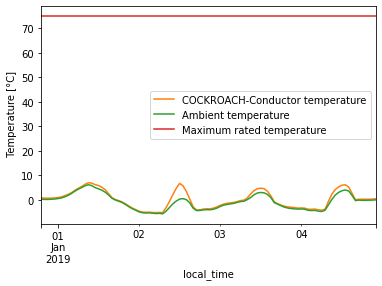

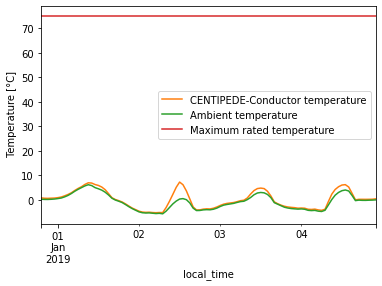

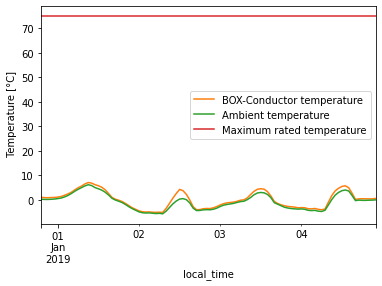

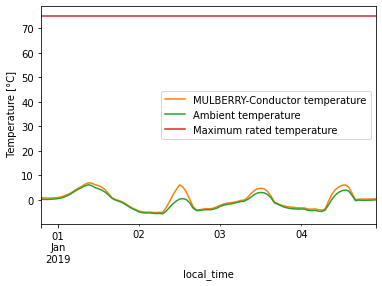

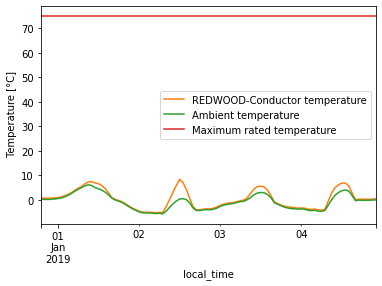

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 11 17:19:45 2021

@author: Rolando
"""
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import math as m
from scipy.optimize import fsolve
from sympy import *
from sympy import symbols, Eq, solve
import warnings
warnings.filterwarnings('ignore', 'The iteration is not making good progress')
#warnings.filterwarnings('ignore', 'invalid value encountered in sqr')
import scipy
from scipy.optimize import root
#from chebpy import chebfun

#%%

weather= pd.read_excel (r'C:\Users\Rolando\Downloads\We will get through this\Code\Weather 2019.xlsx', parse_dates=(True))
data_AAC= pd.read_excel (r'C:\Users\Rolando\Downloads\We will get through this\Code\Conductors.xlsx', sheet_name = 'AAC')
data_AAAC= pd.read_excel (r'C:\Users\Rolando\Downloads\We will get through this\Code\Conductors.xlsx', sheet_name = 'AAAC')

#Define input variables
t1= weather['local_time']
time= t1[0:8760]
ta1=weather['temperature [C]']
Ta= ta1[0:8760]
sr= weather['radiation_surface [W/m2]']
Sr= sr[0:8760]
Ts= np.array([75]*len(time))
Wd= np.array([0]*len(time))
ws= weather['wind_speed [m/s]']
Ws=  np.array([ws[0:8760]]).T

#Define conductors properties
midge= data_AAC.loc[0,['Nominal Area [mm2]','Overall diameter [mm]', 'Rdc [ohm/km]']]
midge_D= np.array([midge['Overall diameter [mm]']]*len(time))
midge_A= np.array([midge['Nominal Area [mm2]']]*len(time))
midge_Rdc= np.array([midge['Rdc [ohm/km]']]*len(time))

cockroach= data_AAC.loc[6,['Nominal Area [mm2]','Overall diameter [mm]', 'Rdc [ohm/km]']]
cockroach_D=np.array( [cockroach['Overall diameter [mm]']]*len(time))
cockroach_A= np.array([cockroach['Nominal Area [mm2]']]*len(time))
cockroach_Rdc= np.array([cockroach['Rdc [ohm/km]']]*len(time))

centipede= data_AAC.loc[8,['Nominal Area [mm2]','Overall diameter [mm]', 'Rdc [ohm/km]']]
centipede_D=np.array( [centipede['Overall diameter [mm]']]*len(time))
centipede_A= np.array([centipede['Nominal Area [mm2]']]*len(time))
centipede_Rdc= np.array([centipede['Rdc [ohm/km]']]*len(time))

box= data_AAAC.loc[0,['Nominal Area [mm2]','Overall diameter [mm]', 'Rdc [ohm/km]']]
box_D=np.array( [box['Overall diameter [mm]']]*len(time))
box_A= np.array([box['Nominal Area [mm2]']]*len(time))
box_Rdc= np.array([box['Rdc [ohm/km]']]*len(time))


mulberry= data_AAAC.loc[7,['Nominal Area [mm2]','Overall diameter [mm]', 'Rdc [ohm/km]']]
mulberry_D=np.array( [mulberry['Overall diameter [mm]']]*len(time))
mulberry_A= np.array([mulberry['Nominal Area [mm2]']]*len(time))
mulberry_Rdc= np.array([mulberry['Rdc [ohm/km]']]*len(time))

redwood= data_AAAC.loc[8,['Nominal Area [mm2]','Overall diameter [mm]', 'Rdc [ohm/km]']]
redwood_D=np.array( [redwood['Overall diameter [mm]']]*len(time))
redwood_A= np.array([redwood['Nominal Area [mm2]']]*len(time))
redwood_Rdc= np.array([redwood['Rdc [ohm/km]']]*len(time))

D= np.array([midge_D,cockroach_D, centipede_D, box_D, mulberry_D, redwood_D]).T
A= np.array([midge_A,cockroach_A, centipede_A, box_D, mulberry_A, redwood_A]).T
Rdc= np.array([midge_Rdc,cockroach_Rdc, centipede_Rdc, box_Rdc, mulberry_Rdc, redwood_Rdc]).T

#%%
#Calculate Solar Heating (Ps) and Radiative cooling (Pr), in [W/m]
alpha_s=0.5
ep=0.5
sigma_b= 5.6697e-8 #boltzmann constant, in W/m^2 K
Tsr=75*np.ones(len(time))
Ps= np.array([alpha_s*Sr*0.001]).T*D
Pr=np.array([m.pi*0.001*sigma_b*ep*((Tsr+273)**4-(Ta+273)**4)]).T*D

#%% Calculate Nusselt numbers

g= 9.807 #gravity constant in m/s^2
Tf=np.array(0.5*(Ts+Ta))
Visco=1.32e-5+9.5e-8*Tf
Prandtl=np.array([0.715-2.5e-4*Tf]).T
Gr=np.array([((Ts-Ta)*g)/((Tf+273.15)*Visco**2)]).T*((0.001*D)**3)

A21=0.850
m21= 0.188
Nu_cv1= np.where(((Gr*Prandtl)>=1e2) & ((Gr*Prandtl)<1e4) , A21*((Gr*Prandtl))**m21, (Gr*Prandtl))

A22= 0.480
m22= 0.250
Nu_cv2= np.where(((Gr*Prandtl)>=1e4) & ((Gr*Prandtl)<=1e6) , A22*((Gr*Prandtl))**m22, Nu_cv1)
Nu_cvf= np.where(((Gr*Prandtl)<1e2) | ((Gr*Prandtl)>1e6) , 0, Nu_cv2)

y = np.array([1600]*len(time))
Rho_r= np.array([np.exp(-1.16e-4*y)]).T
d= np.array([[3.178]*len(time)]).T
Rf= d/(2*(D-2*d))
visco=np.array([1.32e-5+9.5e-8*Tf]).T
Re= (Rho_r*Ws*D*0.001)/visco

B11= 0.641
n11= 0.471
Nu_11= np.where(((Re>=0) & (Re<=2.65e3)), B11*(Re)**n11, Re)

B12= 0.178
n12= 0.633
Nu_12= np.where(((Re>2.65e3) & (Rf<=0.05)), B12*(Re)**n12, Nu_11)

B13= 0.048
n13= 0.800
Nu_13= np.where(((Re>2.65e3) & (Rf>0.05)), B13*(Re)**n13, Nu_12)

Nu_1= np.where(((Re<0)), 0, Nu_13)

Wd_m= np.array([Wd]*len((np.array([midge_D,cockroach_D, centipede_D, box_D, mulberry_D, redwood_D])))).T
Ws_m=np.array([ws[0:8760]]*len((np.array([midge_D,cockroach_D, centipede_D, box_D, mulberry_D, redwood_D])))).T


A11= 0.42
B21= 0.68
m11= 1.08
gamma1=(A11+B21*(np.sin(np.radians(Wd_m)))**m11)

A12= 0.42
B22= 0.58
m12=0.90
gamma2= (A12+B22*(np.sin(np.radians(Wd_m)))**m12)

Nu_21= np.where(((Wd_m>0) & (Wd_m<=24)), Nu_1*gamma1, Wd_m)
Nu_22= np.where(((Wd_m>24) & (Wd_m<=90)), Nu_1*gamma2, Nu_21)
Nu_2= np.where(((Wd_m==0) | (Wd_m==180) | (Wd_m==360)), Nu_1*0.42, Nu_22)

#Calculation of the corrected Nu
Nu_corr= 0.55*Nu_1

#%%

Nu2t=  Nu_1* (A12+B22*(np.sin(np.radians(45)))**m12)
Nu_h= np.maximum.reduce([Nu2t,Nu_corr,Nu_cvf])
 
#Calculate the natural Nu
Lambda_f= np.array([2.42e-2+7.2e-5*Tf]).T
hc= np.array([[2.5]*len(time)]).T 
Nu= (hc*D*0.001)/Lambda_f

#%% Calculate Convective Cooling (Pc), in [W/m]

delta= np.array([Ts-Ta]).T

Pc_1= np.where(((Ws_m>0) & (Ws_m<0.5)), m.pi*Lambda_f*(delta)*Nu_h, Ws_m)
Pc_2= np.where((Ws_m>=0.5), m.pi*Lambda_f*(delta)*Nu_2, Pc_1)
Pc_3= np.where((Ws_m==0), m.pi*Lambda_f*(delta)*Nu, Pc_2)
Pc= np.where((Ws_m<0), 0, Pc_3)

#%% Calculate currents Idc and Iac

Tav=np.array([Ts]).T
alpha= np.array([[0.0039]*len(time)]).T 
nl= np.array([[3]*len(time)]).T 
Idc= np.sqrt((Pc+Pr-Ps)/(Rdc*0.001*(1+alpha*(Tav-20))))

#Create matrix  Ik
Ik_2= Idc/(A)
iac_3= Idc/np.sqrt(1+0.02*(25.62-133.9*Ik_2+288.8* Ik_2**2- 334.5* Ik_2**3 +226.5* Ik_2**4-89.73* Ik_2**5+ 19.31* Ik_2**6-1.744*Ik_2**7))
iac_4= Idc/np.sqrt(1+0.02*(2.978-22.02*pow(Ik_2,1)+24.87* pow(Ik_2,2)- 11.64* pow(Ik_2,3) +2.973* pow(Ik_2,4)-0.4135* pow(Ik_2,5)+ 0.02445* pow(Ik_2,6)))
iac_5= Idc/np.sqrt(1.1)

#Fill nan
Idc[np.isnan(Idc)] = 0
Ik_2[np.isnan(Ik_2)] = 0
iac_3[np.isnan(iac_3)] = 0
iac_4[np.isnan(iac_4)] = 0
iac_5[np.isnan(iac_5)] = 0

Iac_1= np.where(((A>=175) & ((nl==1) | (nl==2))), Idc/np.sqrt(1.0145+0.09e-6*Idc), A)
Iac_2= np.where((((A>0) & (A<175)) & ((nl==1) | (nl==2)) & (Ik_2<=0.742)), Idc, Iac_1)

#Indexed conditionals
Iac_3= np.where((((A>0) & (A<175)) & ((nl==1) | (nl==2)) & ((Ik_2>0.742) & (Ik_2<=2.486))), iac_3, Iac_2)
Iac_4= np.where((((A>0) & (A<175)) & ((nl==1) | (nl==2)) & ((Ik_2>2.486) & (Ik_2<=3.908))), iac_4, Iac_3)
Iac_5= np.where((((A>0) & (A<175)) & ((nl==1) | (nl==2)) & (Ik_2>3.908)), iac_5, Iac_4)

Iac_6= np.where((nl>=3), Idc/np.sqrt(1.0123+2.319e-5*Idc), 0)
Iac=Iac_6

#%%Calculate Joule Heating (Pj), in W/m. Using the current Idc previously calculated

Pj= pow(Idc,2)*0.001*Rdc*(1+alpha*(Tav-20))

#%%Calculate the rating by using the load factor

load= weather['power [dim.less]']
Load= np.array([load[0:8760]]).T

#%%Plot

#colors= https://matplotlib.org/stable/users/dflt_style_changes.html


#%% Conservative process 

#Input
Sr_con= np.array([1200]*len(time))
Ta_con= np.array([25]*len(time))
Ts_con= np.array([75]*len(time))
Wd_con= np.array([0]*len(time))
Ws_con= np.array([[0.5]*len(time)]).T

#Calculated
Tf_con=np.array(0.5*(Ts_con+Ta_con))
Lambda_fcon= np.array([2.42e-2+7.2e-5*Tf_con]).T
delta_con= np.array([Ts_con-Ta_con]).T
Visco_con= np.array([1.32e-5+9.5e-8*Tf_con]).T
Re_con= (Rho_r*Ws_con*D*0.001)/Visco_con
Nu1_con= 0.42*(B11*(Re_con)**n11) #Because the wind direction equals 0 m/s
                
Ps_con= np.array([alpha_s*Sr_con*0.001]).T*D
#Ts_r= np.array([298]*len(time))
Ts_r= 348*np.ones(len(time))
Ta_r= 298*np.ones(len(time))
Pr_con= np.array([m.pi*0.001*sigma_b*ep*((Ts_r)**4-(Ta_r)**4)]).T*D
Pc_con=  m.pi*Lambda_fcon*(delta_con)*Nu1_con

Tav_con= np.array([Ts_con]).T
Idc_con= np.sqrt((Pc_con+Pr_con-Ps_con)/(Rdc*0.001*(1+alpha*(Tav_con-20))))
Idc_con[np.isnan(Idc_con)] = 0
Iac_con= Idc_con/np.sqrt(1.0123+2.319e-5*Idc_con)
Rating= Load* Iac_con


Midge_Iac=pd.DataFrame({'MIDGE - Dynamic Line rating':np.ravel(Iac[:,[0]])})
Midge_Sta= pd.DataFrame({'MIDGE - Static rating':np.ravel(Iac_con[:,[0]])})

Midge_Rating=pd.DataFrame({'MIDGE - Current':np.ravel(Rating[:,[0]])})
Midge_time= pd.concat([time, Midge_Iac, Midge_Rating, Midge_Sta], axis=1, join='inner')
df_Mid= Midge_time.set_index('local_time')
df_Mid.plot()
plt.ylabel("Current [A]")
plt.show()


Cockr_Iac=pd.DataFrame({'COCKROACH - Dynamic Line rating':np.ravel(Iac[:,[1]])})
Cockr_Sta= pd.DataFrame({'COCKROACH- Static rating':np.ravel(Iac_con[:,[1]])})

Cockr_Rating=pd.DataFrame({'COCKROACH - Current':np.ravel(Rating[:,[1]])})
Cockr_time= pd.concat([time, Cockr_Iac, Cockr_Rating, Cockr_Sta], axis=1, join='inner')
df_Cockr= Cockr_time.set_index('local_time')
df_Cockr.plot()
plt.ylabel("Current [A]")
plt.show()

Cent_Iac=pd.DataFrame({'CENTIPEDE - Dynamic Line rating':np.ravel(Iac[:,[2]])})
Cent_Sta= pd.DataFrame({'CENTIPEDE- Static rating':np.ravel(Iac_con[:,[2]])})

Cent_Rating=pd.DataFrame({'CENTIPEDE - Current':np.ravel(Rating[:,[2]])})
Cent_time= pd.concat([time, Cent_Iac, Cent_Rating, Cent_Sta], axis=1, join='inner')
df_Cent= Cent_time.set_index('local_time')
df_Cent.plot()
plt.ylabel("Current [A]")
plt.show()

Box_Iac=pd.DataFrame({'BOX - Dynamic Line rating':np.ravel(Iac[:,[3]])})
Box_Sta= pd.DataFrame({'BOX- Static rating':np.ravel(Iac_con[:,[3]])})

Box_Rating=pd.DataFrame({'BOX - Current':np.ravel(Rating[:,[3]])})
Box_time= pd.concat([time, Box_Iac, Box_Rating, Box_Sta], axis=1, join='inner')
df_Box= Box_time.set_index('local_time')
df_Box.plot()
plt.ylabel("Current [A]")
plt.show()

Mul_Iac=pd.DataFrame({'MULBERRY - Dynamic Line rating':np.ravel(Iac[:,[4]])})
Mul_Sta= pd.DataFrame({'MULBERRY- Static rating':np.ravel(Iac_con[:,[4]])})

Mul_Rating=pd.DataFrame({'MULBERRY - Current':np.ravel(Rating[:,[4]])})
Mul_time= pd.concat([time, Mul_Iac, Mul_Rating, Mul_Sta], axis=1, join='inner')
df_Mul= Mul_time.set_index('local_time')
df_Mul.plot()
plt.ylabel("Current [A]")
plt.show()

Red_Iac=pd.DataFrame({'REDWOOD -  Dynamic Line rating':np.ravel(Iac[:,[5]])})
Red_Sta= pd.DataFrame({'REDWOOD- Static rating':np.ravel(Iac_con[:,[5]])})


Red_Rating=pd.DataFrame({'REDWOOD - Current':np.ravel(Rating[:,[5]])})
Red_time= pd.concat([time, Red_Iac, Red_Rating, Red_Sta], axis=1, join='inner')
df_Red= Red_time.set_index('local_time')
df_Red.plot()
plt.ylabel("Current [A]")
plt.show()


#%%

Pj_con= pow(Rating,2)*0.001*Rdc*(1+alpha*(Tav-20))

eta0= np.array([m.pi*0.001*sigma_b*ep]).T*D[0:8000,[0]]
Eta0= np.ravel(eta0)
Pj0= np.ravel(Pj_con[0:8000,[0]])
Ps0=np.ravel(Ps[0:8000,[0]])
Pc0= np.ravel(Pc[0:8000,[0]])
tf0=np.ravel(Tf[0:8000])
delta0=np.ravel(Ts[0:8000]-Ta[0:8000])
lambda_f0=np.ravel(2.42e-2+7.2e-5*tf0)
Nux0= Pc0/(m.pi*lambda_f0*(delta0))
ta0=np.ravel(Ta[0:100])

eta1= np.array([m.pi*0.001*sigma_b*ep]).T*D[0:8000,[1]]
Eta1= np.ravel(eta1)
Pj1= np.ravel(Pj_con[0:8000,[1]])
Ps1=np.ravel(Ps[0:8000,[1]])
Pc1= np.ravel(Pc[0:8000,[1]])
tf1=np.ravel(Tf[0:8000])
delta1=np.ravel(Ts[0:8000]-Ta[0:8000])
lambda_f1=np.ravel(2.42e-2+7.2e-5*tf1)
Nux1= Pc1/(m.pi*lambda_f1*(delta1))
ta1=np.ravel(Ta[0:8000])

eta2= np.array([m.pi*0.001*sigma_b*ep]).T*D[0:8000,[2]]
Eta2= np.ravel(eta2)
Pj2= np.ravel(Pj_con[0:8000,[2]])
Ps2=np.ravel(Ps[0:8000,[2]])
Pc2= np.ravel(Pc[0:8000,[2]])
tf2=np.ravel(Tf[0:8000])
delta2=np.ravel(Ts[0:8000]-Ta[0:8000])
lambda_f2=np.ravel(2.42e-2+7.2e-5*tf2)
Nux2= Pc2/(m.pi*lambda_f2*(delta2))
ta2=np.ravel(Ta[0:8000])

eta3= np.array([m.pi*0.001*sigma_b*ep]).T*D[0:8000,[3]]
Eta3= np.ravel(eta3)
Pj3= np.ravel(Pj_con[0:8000,[3]])
Ps3=np.ravel(Ps[0:8000,[3]])
Pc3= np.ravel(Pc[0:8000,[3]])
tf3=np.ravel(Tf[0:8000])
delta3=np.ravel(Ts[0:8000]-Ta[0:8000])
lambda_f3=np.ravel(2.42e-2+7.2e-5*tf3)
Nux3= Pc3/(m.pi*lambda_f3*(delta3))
ta3=np.ravel(Ta[0:8000])

eta4= np.array([m.pi*0.001*sigma_b*ep]).T*D[0:8000,[4]]
Eta4= np.ravel(eta4)
Pj4= np.ravel(Pj_con[0:8000,[4]])
Ps4=np.ravel(Ps[0:8000,[4]])
Pc4= np.ravel(Pc[0:8000,[4]])
tf4=np.ravel(Tf[0:8000])
delta4=np.ravel(Ts[0:8000]-Ta[0:8000])
lambda_f4=np.ravel(2.42e-2+7.2e-5*tf4)
Nux4= Pc4/(m.pi*lambda_f4*(delta4))
ta4=np.ravel(Ta[0:8000])

eta5= np.array([m.pi*0.001*sigma_b*ep]).T*D[0:8000,[5]]
Eta5= np.ravel(eta5)
Pj5= np.ravel(Pj_con[0:8000,[5]])
Ps5=np.ravel(Ps[0:8000,[5]])
Pc5= np.ravel(Pc[0:8000,[5]])
tf5=np.ravel(Tf[0:8000])
delta5=np.ravel(Ts[0:8000]-Ta[0:8000])
lambda_f5=np.ravel(2.42e-2+7.2e-5*tf5)
Nux5= Pc5/(m.pi*lambda_f5*(delta5))
ta5=np.ravel(Ta[0:8000])

def funcTcx0(Tc):
    eta0= np.array([m.pi*0.001*sigma_b*ep]).T*D[0:700,[0]]
    Eta0= np.ravel(eta0)
    Pj0= np.ravel(Pj_con[0:700,[0]])
    Ps0=np.ravel(Ps[0:700,[0]])
    Pc0= np.ravel(Pc[0:700,[0]])
    tf0=np.ravel(Tf[0:700])
    delta0=np.ravel(Ts[0:700]-Ta[0:700])
    lambda_f0=np.ravel(2.42e-2+7.2e-5*tf0)
    Nux0= Pc0/(m.pi*lambda_f0*(delta0))
    ta0=np.ravel(Ta[0:700])
    return np.array((Pj0)+Ps0-(Eta0*((Tc+273)**4-(ta0+273)**4))-((m.pi*(Tc-ta0))*Nux0))
   
answer0=[]
answer1=[]
answer2=[]
answer3=[]
answer4=[]
answer5=[]
x = symbols('x', real= True)

for N in range(100): 
    result0 = solve(Pj0[N]+Ps0[N]-(Eta0[N]*((x+273)**4-(ta0[N]+273)**4))-((m.pi*(2.42e-2+7.2e-5*(0.5*(x+ta0[N])))*(x-ta0[N]))*Nux0[N]))
    result1 = solve(Pj1[N]+Ps1[N]-(Eta1[N]*((x+273)**4-(ta1[N]+273)**4))-((m.pi*(2.42e-2+7.2e-5*(0.5*(x+ta1[N])))*(x-ta1[N]))*Nux1[N]))
    result2 = solve(Pj2[N]+Ps2[N]-(Eta2[N]*((x+273)**4-(ta2[N]+273)**4))-((m.pi*(2.42e-2+7.2e-5*(0.5*(x+ta2[N])))*(x-ta2[N]))*Nux2[N]))
    result3 = solve(Pj3[N]+Ps3[N]-(Eta3[N]*((x+273)**4-(ta3[N]+273)**4))-((m.pi*(2.42e-2+7.2e-5*(0.5*(x+ta3[N])))*(x-ta3[N]))*Nux3[N]))
    result4 = solve(Pj4[N]+Ps4[N]-(Eta4[N]*((x+273)**4-(ta4[N]+273)**4))-((m.pi*(2.42e-2+7.2e-5*(0.5*(x+ta4[N])))*(x-ta4[N]))*Nux4[N]))
    result5 = solve(Pj5[N]+Ps5[N]-(Eta5[N]*((x+273)**4-(ta5[N]+273)**4))-((m.pi*(2.42e-2+7.2e-5*(0.5*(x+ta5[N])))*(x-ta5[N]))*Nux5[N]))
    answer0.append(result0)
    answer1.append(result1)
    answer2.append(result2)
    answer3.append(result3)
    answer4.append(result4)
    answer5.append(result5)

final0=pd.DataFrame(answer0)
final_Mid= final0.iloc[:,[1]]
final_Mid= final_Mid.astype(float)

final1=pd.DataFrame(answer1)
final_Cockr= final1.iloc[:,[1]]
final_Cockr= final_Cockr.astype(float)

final2=pd.DataFrame(answer2)
final_Cent= final2.iloc[:,[1]]
final_Cent= final_Cent.astype(float)

final3=pd.DataFrame(answer3)
final_Box= final3.iloc[:,[1]]
final_Box= final_Box.astype(float)

final4=pd.DataFrame(answer4)
final_Mul= final4.iloc[:,[1]]
final_Mul= final_Mul.astype(float)

final5=pd.DataFrame(answer5)
final_Red= final5.iloc[:,[1]]
final_Red= final_Red.astype(float)


Max_T=pd.DataFrame({'Maximum rated temperature': np.ravel(Ts_con)})

Midge_Tc=pd.DataFrame({'MIDGE-Conductor temperature': np.ravel(final_Mid)})
Midge_Ta= pd.DataFrame({'Ambient temperature': np.ravel(ta0)})
Midge_T= pd.concat([time, Midge_Tc, Midge_Ta, Max_T], axis=1, join='inner')
df_Tc0= Midge_T.set_index('local_time')
df_Tc0.plot(color=["C1", "C2", "C3"])
plt.ylabel(" Temperature [°C]")
plt.show()

Cockr_Tc=pd.DataFrame({'COCKROACH-Conductor temperature': np.ravel(final_Cockr)})
Cockr_T= pd.concat([time, Cockr_Tc, Midge_Ta, Max_T], axis=1, join='inner')
df_Tc1= Cockr_T.set_index('local_time')
df_Tc1.plot(color=["C1", "C2", "C3"])
plt.ylabel(" Temperature [°C]")
plt.show()

Cent_Tc=pd.DataFrame({'CENTIPEDE-Conductor temperature': np.ravel(final_Cent)})
Cent_T= pd.concat([time, Cent_Tc, Midge_Ta, Max_T], axis=1, join='inner')
df_Tc2= Cent_T.set_index('local_time')
df_Tc2.plot(color=["C1", "C2", "C3"])
plt.ylabel(" Temperature [°C]")
plt.show()

Box_Tc=pd.DataFrame({'BOX-Conductor temperature': np.ravel(final_Box)})
Box_T= pd.concat([time, Box_Tc, Midge_Ta, Max_T], axis=1, join='inner')
df_Tc3= Box_T.set_index('local_time')
df_Tc3.plot(color=["C1", "C2", "C3"])
plt.ylabel(" Temperature [°C]")
plt.show()

Mul_Tc=pd.DataFrame({'MULBERRY-Conductor temperature': np.ravel(final_Mul)})
Mul_T= pd.concat([time, Mul_Tc, Midge_Ta, Max_T], axis=1, join='inner')
df_Tc4= Mul_T.set_index('local_time')
df_Tc4.plot(color=["C1", "C2", "C3"])
plt.ylabel(" Temperature [°C]")
plt.show()


Red_Tc=pd.DataFrame({'REDWOOD-Conductor temperature': np.ravel(final_Red)})
Red_T= pd.concat([time, Red_Tc, Midge_Ta, Max_T], axis=1, join='inner')
df_Tc5= Red_T.set_index('local_time')
df_Tc5.plot(color=["C1", "C2", "C3"])
plt.ylabel(" Temperature [°C]")
plt.show()